# Entrenamiento y Validacion de Modelos: Prediccion de Podio en F1

## Objetivo
Este notebook implementa el entrenamiento, optimizacion y validacion de multiples algoritmos de Machine Learning para predecir podios en Formula 1.

## Contenido
1. Carga de datos procesados
2. Definicion de metricas de evaluacion
3. Entrenamiento de 5+ algoritmos con GridSearchCV
4. Comparacion exhaustiva de resultados
5. Analisis del mejor modelo
6. Validacion con ejemplos reales
7. Guardado del modelo final

## Algoritmos a Entrenar
1. Logistic Regression (baseline)
2. Random Forest Classifier
3. XGBoost Classifier
4. LightGBM Classifier
5. CatBoost Classifier
6. Gradient Boosting Classifier (adicional)

---
## 1. Importar Librerias y Configuracion

In [1]:
!apt-get update && apt-get install -y libgomp1

Get:1 http://deb.debian.org/debian trixie InRelease [140 kB]
Get:2 http://deb.debian.org/debian trixie-updates InRelease [47.3 kB]
Get:3 http://deb.debian.org/debian-security trixie-security InRelease [43.4 kB]
Get:4 http://deb.debian.org/debian trixie/main amd64 Packages [9669 kB]
Get:5 http://deb.debian.org/debian trixie-updates/main amd64 Packages [5412 B]
Get:6 http://deb.debian.org/debian-security trixie-security/main amd64 Packages [62.7 kB]
Fetched 9968 kB in 1s (10.1 MB/s)                     
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libgomp1
0 upgraded, 1 newly installed, 0 to remove and 0 not upgraded.
Need to get 137 kB of archives.
After this operation, 377 kB of additional disk space will be used.
Get:1 http://deb.debian.org/debian trixie/main amd64 libgomp1 amd64 14.2.0-19 [137 kB]
Fetched 137 kB in 0s (1401 kB/s)
debconf: unable to initial

In [2]:
%pip install xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 45.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 77.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 47.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 22.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Librerias basicas
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
import time
import joblib

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, precision_score, recall_score, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

# XGBoost, LightGBM, CatBoost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

print("Librerias importadas correctamente")
print(f"Fecha y hora de inicio: {time.strftime('%Y-%m-%d %H:%M:%S')}")

Librerias importadas correctamente
Fecha y hora de inicio: 2025-10-25 16:49:32


In [4]:
# Configuracion
DATA_PATH = "data/processed/"
MODELS_PATH = "models/"
USE_SMOTE = True  # Cambiar a False para usar datos sin balancear

# Crear directorio de modelos
os.makedirs(MODELS_PATH, exist_ok=True)

# Configuracion de visualizacion
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Configuracion establecida")
print(f"Usar datos balanceados (SMOTE): {USE_SMOTE}")
print(f"Random state: {RANDOM_STATE}")

Configuracion establecida
Usar datos balanceados (SMOTE): True
Random state: 42


---
## 2. Carga de Datos Procesados

In [5]:
print("Cargando datos procesados...")

# Cargar datos
if USE_SMOTE:
    X_train = pd.read_csv(f'{DATA_PATH}model4_X_train_smote.csv')
    y_train = np.load(f'{DATA_PATH}model4_y_train_smote.npy')
    print("  Usando datos balanceados con SMOTE")
else:
    X_train = pd.read_csv(f'{DATA_PATH}model4_X_train.csv')
    y_train = np.load(f'{DATA_PATH}model4_y_train.npy')
    print("  Usando datos originales sin balancear")

X_test = pd.read_csv(f'{DATA_PATH}model4_X_test.csv')
y_test = np.load(f'{DATA_PATH}model4_y_test.npy')

print(f"\nDatos cargados exitosamente:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")

# Verificar balance
train_balance = pd.Series(y_train).value_counts()
test_balance = pd.Series(y_test).value_counts()

print(f"\nBalance Train:")
print(f"  No Podio (0): {train_balance[0]:,} ({100*train_balance[0]/len(y_train):.2f}%)")
print(f"  Podio (1): {train_balance[1]:,} ({100*train_balance[1]/len(y_train):.2f}%)")

print(f"\nBalance Test:")
print(f"  No Podio (0): {test_balance[0]:,} ({100*test_balance[0]/len(y_test):.2f}%)")
print(f"  Podio (1): {test_balance[1]:,} ({100*test_balance[1]/len(y_test):.2f}%)")

Cargando datos procesados...
  Usando datos balanceados con SMOTE

Datos cargados exitosamente:
  X_train: (17596, 190)
  y_train: (17596,)
  X_test: (602, 190)
  y_test: (602,)

Balance Train:
  No Podio (0): 11,731 (66.67%)
  Podio (1): 5,865 (33.33%)

Balance Test:
  No Podio (0): 500 (83.06%)
  Podio (1): 102 (16.94%)


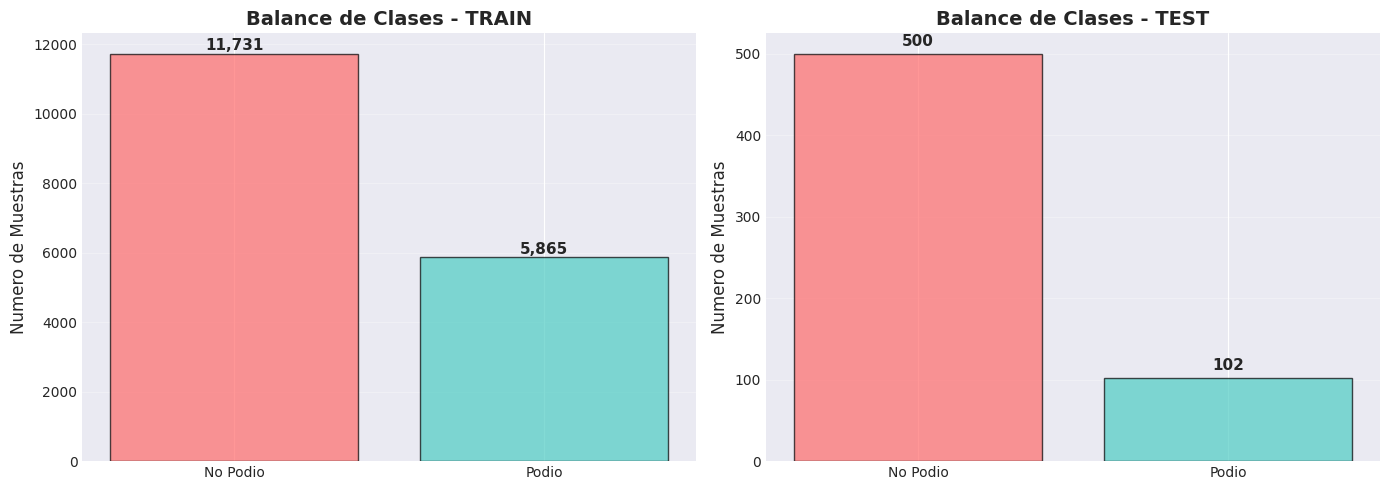

In [6]:
# Visualizacion del balance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train
colors = ['#FF6B6B', '#4ECDC4']
axes[0].bar(['No Podio', 'Podio'], train_balance.values, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Numero de Muestras', fontsize=12)
axes[0].set_title('Balance de Clases - TRAIN', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(train_balance.values):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', fontsize=11, fontweight='bold')

# Test
axes[1].bar(['No Podio', 'Podio'], test_balance.values, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Numero de Muestras', fontsize=12)
axes[1].set_title('Balance de Clases - TEST', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(test_balance.values):
    axes[1].text(i, v + 10, f'{v:,}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 3. Definicion de Metricas de Evaluacion

**Metricas principales**:
- **F1-Score**: Balance entre precision y recall
- **Precision**: De los predichos como Podio, cuantos son correctos
- **Recall**: De los Podios reales, cuantos detectamos
- **ROC-AUC**: Capacidad discriminativa del modelo

In [7]:
def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="Modelo"):
    """
    Evalua un modelo de clasificacion con multiples metricas
    """
    print(f"\n{'='*80}")
    print(f"EVALUACION: {model_name}")
    print(f"{'='*80}")
    
    # Metricas basicas
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    print(f"\nMetricas de Clasificacion:")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    
    # ROC-AUC (si hay probabilidades)
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        print(f"  ROC-AUC:   {roc_auc:.4f}")
    else:
        roc_auc = None
    
    # Matriz de confusion
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nMatriz de Confusion:")
    print(f"  TN: {cm[0,0]}  |  FP: {cm[0,1]}")
    print(f"  FN: {cm[1,0]}  |  TP: {cm[1,1]}")
    
    # Reporte de clasificacion
    print(f"\nReporte de Clasificacion:")
    print(classification_report(y_true, y_pred, target_names=['No Podio', 'Podio']))
    
    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

print("Funcion de evaluacion definida")

Funcion de evaluacion definida


---
## 4. Entrenamiento de Modelos con GridSearchCV

### 4.1 Logistic Regression (Baseline)

In [8]:
print("\n" + "="*80)
print("MODELO 1: LOGISTIC REGRESSION (BASELINE)")
print("="*80)

# Definir grilla de hiperparametros
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [1000]
}

# Crear modelo
lr_model = LogisticRegression(random_state=RANDOM_STATE)

# GridSearchCV
print("\nIniciando GridSearchCV...")
start_time = time.time()

grid_lr = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid_lr,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"\nGridSearchCV completado en {elapsed_time:.2f} segundos")

# Mejores parametros
print(f"\nMejores parametros:")
for param, value in grid_lr.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor F1-Score (CV): {grid_lr.best_score_:.4f}")

# Predicciones en test
y_pred_lr = grid_lr.predict(X_test)
y_pred_proba_lr = grid_lr.predict_proba(X_test)[:, 1]

# Evaluacion
results_lr = evaluate_model(y_test, y_pred_lr, y_pred_proba_lr, "Logistic Regression")


MODELO 1: LOGISTIC REGRESSION (BASELINE)

Iniciando GridSearchCV...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


GridSearchCV completado en 19.62 segundos

Mejores parametros:
  C: 0.1
  max_iter: 1000
  penalty: l2
  solver: liblinear

Mejor F1-Score (CV): 0.6980

EVALUACION: Logistic Regression

Metricas de Clasificacion:
  F1-Score:  0.6703
  Precision: 0.7625
  Recall:    0.5980
  ROC-AUC:   0.9329

Matriz de Confusion:
  TN: 481  |  FP: 19
  FN: 41  |  TP: 61

Reporte de Clasificacion:
              precision    recall  f1-score   support

    No Podio       0.92      0.96      0.94       500
       Podio       0.76      0.60      0.67       102

    accuracy                           0.90       602
   macro avg       0.84      0.78      0.81       602
weighted avg       0.89      0.90      0.90       602



### 4.2 Random Forest Classifier

In [9]:
print("\n" + "="*80)
print("MODELO 2: RANDOM FOREST CLASSIFIER")
print("="*80)

# Grilla de hiperparametros
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

# Crear modelo
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

# GridSearchCV
print("\nIniciando GridSearchCV...")
print("ADVERTENCIA: Esto puede tardar varios minutos...")
start_time = time.time()

grid_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"\nGridSearchCV completado en {elapsed_time:.2f} segundos ({elapsed_time/60:.1f} minutos)")

# Mejores parametros
print(f"\nMejores parametros:")
for param, value in grid_rf.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor F1-Score (CV): {grid_rf.best_score_:.4f}")

# Predicciones
y_pred_rf = grid_rf.predict(X_test)
y_pred_proba_rf = grid_rf.predict_proba(X_test)[:, 1]

# Evaluacion
results_rf = evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, "Random Forest")


MODELO 2: RANDOM FOREST CLASSIFIER

Iniciando GridSearchCV...
ADVERTENCIA: Esto puede tardar varios minutos...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

GridSearchCV completado en 158.61 segundos (2.6 minutos)

Mejores parametros:
  class_weight: balanced
  max_depth: 10
  min_samples_leaf: 4
  min_samples_split: 10
  n_estimators: 100

Mejor F1-Score (CV): 0.6725

EVALUACION: Random Forest

Metricas de Clasificacion:
  F1-Score:  0.6694
  Precision: 0.5685
  Recall:    0.8137
  ROC-AUC:   0.9332

Matriz de Confusion:
  TN: 437  |  FP: 63
  FN: 19  |  TP: 83

Reporte de Clasificacion:
              precision    recall  f1-score   support

    No Podio       0.96      0.87      0.91       500
       Podio       0.57      0.81      0.67       102

    accuracy                           0.86       602
   macro avg       0.76      0.84      0.79       602
weighted avg       0.89      0.86      0.87       602



### 4.3 XGBoost Classifier

In [10]:
print("\n" + "="*80)
print("MODELO 3: XGBOOST CLASSIFIER")
print("="*80)

# Calcular scale_pos_weight
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count
print(f"\nscale_pos_weight calculado: {scale_pos_weight:.2f}")

# Grilla de hiperparametros
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [scale_pos_weight, scale_pos_weight * 0.8, scale_pos_weight * 1.2]
}

# Crear modelo
xgb_model = XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss')

# GridSearchCV
print("\nIniciando GridSearchCV...")
print("ADVERTENCIA: Esto puede tardar varios minutos...")
start_time = time.time()

grid_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"\nGridSearchCV completado en {elapsed_time:.2f} segundos ({elapsed_time/60:.1f} minutos)")

# Mejores parametros
print(f"\nMejores parametros:")
for param, value in grid_xgb.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor F1-Score (CV): {grid_xgb.best_score_:.4f}")

# Predicciones
y_pred_xgb = grid_xgb.predict(X_test)
y_pred_proba_xgb = grid_xgb.predict_proba(X_test)[:, 1]

# Evaluacion
results_xgb = evaluate_model(y_test, y_pred_xgb, y_pred_proba_xgb, "XGBoost")


MODELO 3: XGBOOST CLASSIFIER

scale_pos_weight calculado: 2.00

Iniciando GridSearchCV...
ADVERTENCIA: Esto puede tardar varios minutos...
Fitting 5 folds for each of 576 candidates, totalling 2880 fits

GridSearchCV completado en 211.03 segundos (3.5 minutos)

Mejores parametros:
  colsample_bytree: 0.8
  learning_rate: 0.01
  max_depth: 3
  n_estimators: 100
  scale_pos_weight: 2.0001705029838024
  subsample: 0.8

Mejor F1-Score (CV): 0.6682

EVALUACION: XGBoost

Metricas de Clasificacion:
  F1-Score:  0.6449
  Precision: 0.5115
  Recall:    0.8725
  ROC-AUC:   0.9344

Matriz de Confusion:
  TN: 415  |  FP: 85
  FN: 13  |  TP: 89

Reporte de Clasificacion:
              precision    recall  f1-score   support

    No Podio       0.97      0.83      0.89       500
       Podio       0.51      0.87      0.64       102

    accuracy                           0.84       602
   macro avg       0.74      0.85      0.77       602
weighted avg       0.89      0.84      0.85       602



### 4.4 LightGBM Classifier

In [13]:
print("\n" + "="*80)
print("MODELO 4: LIGHTGBM CLASSIFIER")
print("="*80)

# Grilla de hiperparametros
param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_samples': [20, 30, 50],
    'is_unbalance': [True, False]
}

# Crear modelo
lgbm_model = LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)

# GridSearchCV
print("\nIniciando GridSearchCV...")
start_time = time.time()

grid_lgbm = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid_lgbm,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_lgbm.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"\nGridSearchCV completado en {elapsed_time:.2f} segundos ({elapsed_time/60:.1f} minutos)")

# Mejores parametros
print(f"\nMejores parametros:")
for param, value in grid_lgbm.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor F1-Score (CV): {grid_lgbm.best_score_:.4f}")

# Predicciones
y_pred_lgbm = grid_lgbm.predict(X_test)
y_pred_proba_lgbm = grid_lgbm.predict_proba(X_test)[:, 1]

# Evaluacion
results_lgbm = evaluate_model(y_test, y_pred_lgbm, y_pred_proba_lgbm, "LightGBM")


MODELO 4: LIGHTGBM CLASSIFIER

Iniciando GridSearchCV...
Fitting 5 folds for each of 162 candidates, totalling 810 fits


KeyboardInterrupt: 

### 4.5 CatBoost Classifier

In [ ]:
print("\n" + "="*80)
print("MODELO 5: CATBOOST CLASSIFIER")
print("="*80)

# Grilla de hiperparametros
param_grid_cat = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'auto_class_weights': ['Balanced', None]
}

# Crear modelo
cat_model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

# GridSearchCV
print("\nIniciando GridSearchCV...")
start_time = time.time()

grid_cat = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid_cat,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_cat.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"\nGridSearchCV completado en {elapsed_time:.2f} segundos ({elapsed_time/60:.1f} minutos)")

# Mejores parametros
print(f"\nMejores parametros:")
for param, value in grid_cat.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor F1-Score (CV): {grid_cat.best_score_:.4f}")

# Predicciones
y_pred_cat = grid_cat.predict(X_test)
y_pred_proba_cat = grid_cat.predict_proba(X_test)[:, 1]

# Evaluacion
results_cat = evaluate_model(y_test, y_pred_cat, y_pred_proba_cat, "CatBoost")


MODELO 5: CATBOOST CLASSIFIER

Iniciando GridSearchCV...
Fitting 5 folds for each of 162 candidates, totalling 810 fits


### 4.6 Gradient Boosting Classifier (Adicional)

In [2]:
print("\n" + "="*80)
print("MODELO 6: GRADIENT BOOSTING CLASSIFIER")
print("="*80)

# Grilla de hiperparametros
param_grid_gb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5]
}

# Crear modelo
gb_model = GradientBoostingClassifier(random_state=RANDOM_STATE)

# GridSearchCV
print("\nIniciando GridSearchCV...")
start_time = time.time()

grid_gb = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid_gb,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_gb.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"\nGridSearchCV completado en {elapsed_time:.2f} segundos ({elapsed_time/60:.1f} minutos)")

# Mejores parametros
print(f"\nMejores parametros:")
for param, value in grid_gb.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor F1-Score (CV): {grid_gb.best_score_:.4f}")

# Predicciones
y_pred_gb = grid_gb.predict(X_test)
y_pred_proba_gb = grid_gb.predict_proba(X_test)[:, 1]

# Evaluacion
results_gb = evaluate_model(y_test, y_pred_gb, y_pred_proba_gb, "Gradient Boosting")


MODELO 6: GRADIENT BOOSTING CLASSIFIER


NameError: name 'GradientBoostingClassifier' is not defined

---
## 5. Comparacion Exhaustiva de Resultados

### 5.1 Tabla Resumen de Metricas

In [3]:
# Consolidar resultados en un DataFrame
results_summary = pd.DataFrame({
    'Modelo': ['Logistic Regression', 'Random Forest', 'XGBoost', 'CatBoost', 'Gradient Boosting'],
    'F1-Score': [
        results_lr['f1'],
        results_rf['f1'],
        results_xgb['f1'],
        results_cat['f1'],
        results_gb['f1']
    ],
    'Precision': [
        results_lr['precision'],
        results_rf['precision'],
        results_xgb['precision'],
        results_cat['precision'],
        results_gb['precision']
    ],
    'Recall': [
        results_lr['recall'],
        results_rf['recall'],
        results_xgb['recall'],
        results_cat['recall'],
        results_gb['recall']
    ],
    'ROC-AUC': [
        results_lr['roc_auc'],
        results_rf['roc_auc'],
        results_xgb['roc_auc'],
        results_cat['roc_auc'],
        results_gb['roc_auc']
    ]
})

# Ordenar por F1-Score
results_summary = results_summary.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("TABLA COMPARATIVA DE RESULTADOS")
print("="*80)
print()
display(results_summary.style.highlight_max(subset=['F1-Score', 'Precision', 'Recall', 'ROC-AUC'], 
                                            color='lightgreen', axis=0))

NameError: name 'pd' is not defined

### 5.2 Graficos Comparativos

In [ ]:
# Grafico de barras comparativo
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['F1-Score', 'Precision', 'Recall', 'ROC-AUC']
colors_palette = plt.cm.Set3(range(len(results_summary)))

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    # Ordenar por metrica actual
    df_sorted = results_summary.sort_values(metric, ascending=True)
    
    ax.barh(df_sorted['Modelo'], df_sorted[metric], color=colors_palette, alpha=0.8, edgecolor='black')
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'Comparacion: {metric}', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Agregar valores
    for i, v in enumerate(df_sorted[metric]):
        ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10, fontweight='bold')

plt.suptitle('Comparacion de Modelos - Todas las Metricas', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 5.3 Curvas ROC Comparativas

In [ ]:
# Curvas ROC de todos los modelos
fig, ax = plt.subplots(figsize=(12, 8))

models_data = [
    ('Logistic Regression', y_pred_proba_lr, results_lr['roc_auc']),
    ('Random Forest', y_pred_proba_rf, results_rf['roc_auc']),
    ('XGBoost', y_pred_proba_xgb, results_xgb['roc_auc']),
    ('LightGBM', y_pred_proba_lgbm, results_lgbm['roc_auc']),
    ('CatBoost', y_pred_proba_cat, results_cat['roc_auc']),
    ('Gradient Boosting', y_pred_proba_gb, results_gb['roc_auc'])
]

for name, y_proba, auc in models_data:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    ax.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})', linewidth=2)

# Linea diagonal (random classifier)
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)

ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('Curvas ROC - Comparacion de Todos los Modelos', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 5.4 Matrices de Confusion Comparativas

In [ ]:
# Matrices de confusion lado a lado
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

confusion_matrices = [
    (results_lr['confusion_matrix'], 'Logistic Regression'),
    (results_rf['confusion_matrix'], 'Random Forest'),
    (results_xgb['confusion_matrix'], 'XGBoost'),
    (results_lgbm['confusion_matrix'], 'LightGBM'),
    (results_cat['confusion_matrix'], 'CatBoost'),
    (results_gb['confusion_matrix'], 'Gradient Boosting')
]

for idx, (cm, name) in enumerate(confusion_matrices):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx],
               xticklabels=['No Podio', 'Podio'],
               yticklabels=['No Podio', 'Podio'])
    axes[idx].set_title(name, fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Real', fontsize=10)
    axes[idx].set_xlabel('Predicho', fontsize=10)

plt.suptitle('Matrices de Confusion - Comparacion', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

---
## 6. Analisis del Mejor Modelo

Seleccionamos el modelo con mejor F1-Score

In [ ]:
# Identificar el mejor modelo
best_model_name = results_summary.iloc[0]['Modelo']
best_f1 = results_summary.iloc[0]['F1-Score']

print("\n" + "="*80)
print(f"MEJOR MODELO: {best_model_name}")
print("="*80)
print(f"\nF1-Score: {best_f1:.4f}")

# Seleccionar el modelo correspondiente
model_map = {
    'Logistic Regression': grid_lr,
    'Random Forest': grid_rf,
    'XGBoost': grid_xgb,
    'LightGBM': grid_lgbm,
    'CatBoost': grid_cat,
    'Gradient Boosting': grid_gb
}

best_model = model_map[best_model_name]
print(f"\nModelo seleccionado: {best_model_name}")

### 6.1 Feature Importance (Top 20)

In [ ]:
# Extraer feature importance (si el modelo lo soporta)
if hasattr(best_model.best_estimator_, 'feature_importances_'):
    importances = best_model.best_estimator_.feature_importances_
    feature_names = X_train.columns
    
    # Crear DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Top 20
    top_features = feature_importance_df.head(20)
    
    print("\nTop 20 Features mas Importantes:")
    display(top_features)
    
    # Visualizacion
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.barh(top_features['Feature'], top_features['Importance'], color='steelblue', alpha=0.8, edgecolor='black')
    ax.set_xlabel('Importancia', fontsize=12, fontweight='bold')
    ax.set_title(f'Top 20 Features - {best_model_name}', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("\nEl modelo seleccionado no soporta feature_importances_")

### 6.2 Curva Precision-Recall

In [ ]:
# Curva Precision-Recall
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]
precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_pred_proba_best)
avg_precision = average_precision_score(y_test, y_pred_proba_best)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(recall_curve, precision_curve, color='blue', linewidth=2, 
       label=f'Precision-Recall (AP = {avg_precision:.4f})')
ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title(f'Curva Precision-Recall - {best_model_name}', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAverage Precision Score: {avg_precision:.4f}")

---
## 7. Validacion con Ejemplos Reales del Test Set

Vamos a seleccionar 15 casos del conjunto de prueba y ver las predicciones del mejor modelo

In [ ]:
# Seleccionar indices aleatorios del test set
np.random.seed(RANDOM_STATE)
sample_indices = np.random.choice(len(X_test), size=15, replace=False)

# Obtener muestras
X_samples = X_test.iloc[sample_indices]
y_samples_true = y_test[sample_indices]

# Predicciones
y_samples_pred = best_model.predict(X_samples)
y_samples_proba = best_model.predict_proba(X_samples)[:, 1]

# Crear DataFrame de resultados
validation_results = pd.DataFrame({
    'Indice': sample_indices,
    'Real': ['Podio' if y == 1 else 'No Podio' for y in y_samples_true],
    'Predicho': ['Podio' if y == 1 else 'No Podio' for y in y_samples_pred],
    'Probabilidad_Podio': y_samples_proba,
    'Correcto': y_samples_true == y_samples_pred
})

print("\n" + "="*80)
print("VALIDACION CON EJEMPLOS REALES")
print("="*80)
print()
display(validation_results)

# Resumen
accuracy_sample = (y_samples_true == y_samples_pred).mean()
print(f"\nPrecision en la muestra: {accuracy_sample:.2%} ({(y_samples_true == y_samples_pred).sum()}/15)")

In [ ]:
# Visualizacion de las predicciones
fig, ax = plt.subplots(figsize=(14, 6))

# Colores: verde para correcto, rojo para incorrecto
colors = ['green' if c else 'red' for c in validation_results['Correcto']]

ax.scatter(range(15), validation_results['Probabilidad_Podio'], c=colors, s=200, alpha=0.6, edgecolor='black')
ax.axhline(y=0.5, color='blue', linestyle='--', linewidth=2, label='Threshold = 0.5')

ax.set_xlabel('Caso de Prueba', fontsize=12, fontweight='bold')
ax.set_ylabel('Probabilidad de Podio', fontsize=12, fontweight='bold')
ax.set_title('Predicciones del Mejor Modelo en Casos Reales', fontsize=14, fontweight='bold')
ax.set_xticks(range(15))
ax.set_xticklabels(range(1, 16))
ax.legend(['Threshold = 0.5', 'Correcto', 'Incorrecto'], fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 7.1 Analisis de Casos Especificos

In [ ]:
# Analizar casos de predicciones correctas e incorrectas
print("\n" + "="*80)
print("ANALISIS DE CASOS ESPECIFICOS")
print("="*80)

# Caso 1: Prediccion correcta de Podio
correct_podium = validation_results[(validation_results['Real'] == 'Podio') & 
                                    (validation_results['Correcto'] == True)]
if len(correct_podium) > 0:
    idx = correct_podium.iloc[0]['Indice']
    prob = correct_podium.iloc[0]['Probabilidad_Podio']
    print(f"\nCASO 1: Prediccion CORRECTA de Podio")
    print(f"  Indice: {idx}")
    print(f"  Probabilidad: {prob:.4f}")
    print(f"  Interpretacion: El modelo esta {prob*100:.1f}% seguro de que es Podio")

# Caso 2: Prediccion correcta de No Podio
correct_no_podium = validation_results[(validation_results['Real'] == 'No Podio') & 
                                       (validation_results['Correcto'] == True)]
if len(correct_no_podium) > 0:
    idx = correct_no_podium.iloc[0]['Indice']
    prob = correct_no_podium.iloc[0]['Probabilidad_Podio']
    print(f"\nCASO 2: Prediccion CORRECTA de No Podio")
    print(f"  Indice: {idx}")
    print(f"  Probabilidad: {prob:.4f}")
    print(f"  Interpretacion: El modelo esta {(1-prob)*100:.1f}% seguro de que NO es Podio")

# Caso 3: Prediccion incorrecta (si hay)
incorrect = validation_results[validation_results['Correcto'] == False]
if len(incorrect) > 0:
    idx = incorrect.iloc[0]['Indice']
    real = incorrect.iloc[0]['Real']
    pred = incorrect.iloc[0]['Predicho']
    prob = incorrect.iloc[0]['Probabilidad_Podio']
    print(f"\nCASO 3: Prediccion INCORRECTA")
    print(f"  Indice: {idx}")
    print(f"  Real: {real}")
    print(f"  Predicho: {pred}")
    print(f"  Probabilidad: {prob:.4f}")
    print(f"  Analisis: El modelo se equivoco, posiblemente por features atipicas")
else:
    print(f"\nNo hubo predicciones incorrectas en esta muestra de 15 casos")

---
## 8. Guardado del Mejor Modelo

In [ ]:
# Guardar el mejor modelo
model_filename = f'{MODELS_PATH}best_podium_classifier_{best_model_name.lower().replace(" ", "_")}.pkl'
joblib.dump(best_model.best_estimator_, model_filename)

print("\n" + "="*80)
print("MODELO GUARDADO")
print("="*80)
print(f"\nArchivo: {model_filename}")
print(f"Modelo: {best_model_name}")
print(f"F1-Score: {best_f1:.4f}")

# Guardar tambien el resumen de resultados
results_summary.to_csv(f'{MODELS_PATH}models_comparison_results.csv', index=False)
print(f"\nTabla de resultados guardada: {MODELS_PATH}models_comparison_results.csv")

---
## 9. Resumen Final y Conclusiones

In [ ]:
print("\n" + "="*80)
print("RESUMEN FINAL - ENTRENAMIENTO DE MODELOS")
print("="*80)

print(f"\n1. MODELOS ENTRENADOS: 6 algoritmos")
for i, model_name in enumerate(results_summary['Modelo'], 1):
    print(f"   {i}. {model_name}")

print(f"\n2. MEJOR MODELO:")
print(f"   Algoritmo: {best_model_name}")
print(f"   F1-Score: {results_summary.iloc[0]['F1-Score']:.4f}")
print(f"   Precision: {results_summary.iloc[0]['Precision']:.4f}")
print(f"   Recall: {results_summary.iloc[0]['Recall']:.4f}")
print(f"   ROC-AUC: {results_summary.iloc[0]['ROC-AUC']:.4f}")

print(f"\n3. RANKING DE MODELOS (por F1-Score):")
for i, row in results_summary.iterrows():
    print(f"   {i+1}. {row['Modelo']}: {row['F1-Score']:.4f}")

print(f"\n4. ARCHIVOS GENERADOS:")
print(f"   - Mejor modelo: {model_filename}")
print(f"   - Tabla de resultados: {MODELS_PATH}models_comparison_results.csv")

print(f"\n5. INTERPRETACION:")
print(f"   - El modelo {best_model_name} es el mejor para predecir podios en F1")
print(f"   - F1-Score de {results_summary.iloc[0]['F1-Score']:.4f} indica buen balance precision/recall")
print(f"   - ROC-AUC de {results_summary.iloc[0]['ROC-AUC']:.4f} indica excelente capacidad discriminativa")

print("\n" + "="*80)
print("ENTRENAMIENTO COMPLETADO EXITOSAMENTE")
print("="*80)
print(f"\nFecha y hora de finalizacion: {time.strftime('%Y-%m-%d %H:%M:%S')}")